# Masking and Cropping Demo on Real Dataset
This notebook demonstrates how masking and cropping operations work on actual training images from the AN2DL dataset.

In [15]:
# 1. Import Libraries and Configure Plotting
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.patches import Rectangle

plt.style.use("default")

def show_images_row(images, titles=None, cmap=None, figsize=(12, 4)):
    """Utility to display a row of images."""
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=figsize)
    if n == 1:
        axes = [axes]
    for i, (img, ax) in enumerate(zip(images, axes)):
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap or "gray")
        else:
            ax.imshow(img)
        ax.axis("off")
        if titles is not None:
            ax.set_title(titles[i])
    plt.tight_layout()
    plt.show()

In [16]:
# 2. Load Sample Images from the Real Dataset
# Path to the training data
data_dir = "../data/train_data"
labels_csv = "../data/train_labels.csv"

# Load the labels
df = pd.read_csv(labels_csv)

# Pick a few samples to visualize
sample_indices = df.head(5)["sample_index"].tolist()

print(f"Loaded {len(df)} training samples")
print(f"Will visualize {len(sample_indices)} samples: {sample_indices}")

Loaded 1412 training samples
Will visualize 5 samples: ['img_0000.png', 'img_0001.png', 'img_0002.png', 'img_0003.png', 'img_0004.png']


Sample: img_0000.png
Image shape: (1097, 1024, 3)
Mask shape: (1097, 1024)
Mask range: [0, 255]


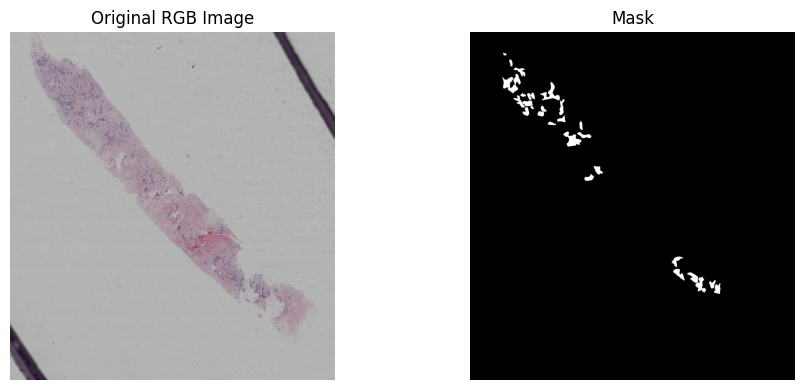

In [17]:
# 3. Load and Display Original Images and Masks
def load_image_and_mask(sample_index, data_dir):
    """Load RGB image and corresponding mask."""
    img_path = os.path.join(data_dir, sample_index)
    mask_id = os.path.splitext(sample_index)[0].split("_")[1]
    mask_path = os.path.join(data_dir, f"mask_{mask_id}.png")
    
    img = Image.open(img_path).convert("RGB")
    mask = Image.open(mask_path).convert("L")
    
    return np.array(img), np.array(mask)

# Load first sample
sample_idx = sample_indices[0]
img, mask = load_image_and_mask(sample_idx, data_dir)

print(f"Sample: {sample_idx}")
print(f"Image shape: {img.shape}")
print(f"Mask shape: {mask.shape}")
print(f"Mask range: [{mask.min()}, {mask.max()}]")

show_images_row([img, mask], ["Original RGB Image", "Mask"], figsize=(10, 4))

Original shape: (1097, 1024, 3)
Cropped shape: (761, 688, 3)
Bounding box: y=[65, 825], x=[101, 788]


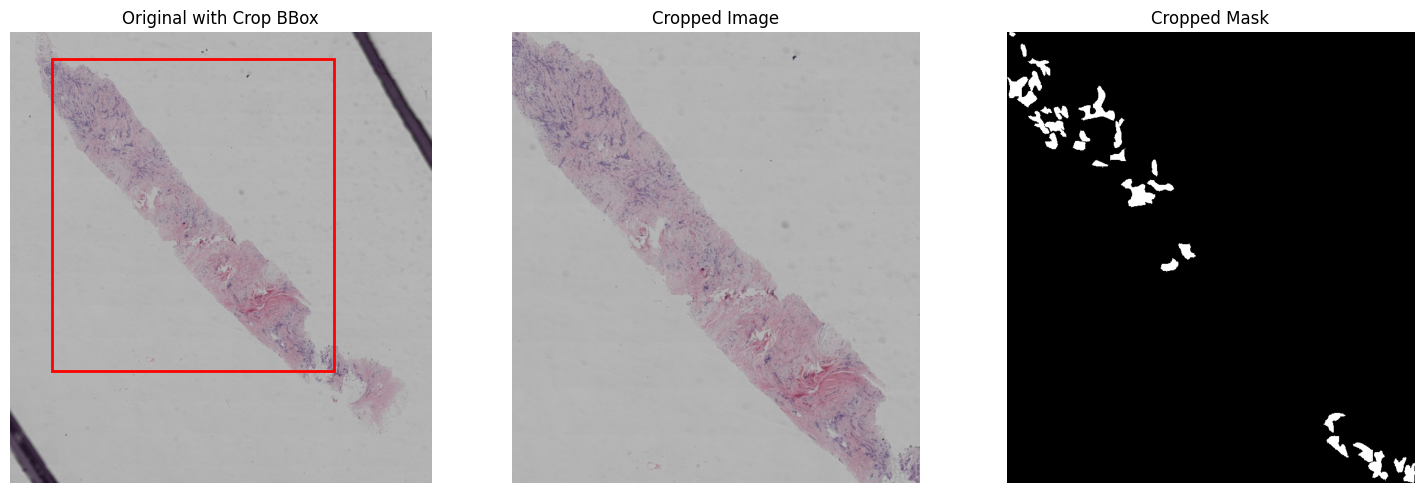

In [18]:
# 4. Apply Bounding Box Cropping (as in training pipeline)
def crop_to_mask_bbox(img, mask):
    """Crop image and mask to the bounding box of non-zero mask pixels."""
    img_cropped = img.copy()
    mask_cropped = mask.copy()
    
    if mask.max() > 0:
        ys, xs = np.where(mask > 0)
        y_min, y_max = ys.min(), ys.max()
        x_min, x_max = xs.min(), xs.max()
        img_cropped = img[y_min:y_max+1, x_min:x_max+1]
        mask_cropped = mask[y_min:y_max+1, x_min:x_max+1]
        return img_cropped, mask_cropped, (y_min, y_max, x_min, x_max)
    
    return img_cropped, mask_cropped, None

img_cropped, mask_cropped, bbox = crop_to_mask_bbox(img, mask)

print(f"Original shape: {img.shape}")
print(f"Cropped shape: {img_cropped.shape}")
print(f"Bounding box: y=[{bbox[0]}, {bbox[1]}], x=[{bbox[2]}, {bbox[3]}]")

# Visualize with bounding box overlay
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img)
rect = Rectangle((bbox[2], bbox[0]), bbox[3]-bbox[2], bbox[1]-bbox[0],
                 linewidth=2, edgecolor="red", facecolor="none")
axes[0].add_patch(rect)
axes[0].set_title("Original with Crop BBox")
axes[0].axis("off")

axes[1].imshow(img_cropped)
axes[1].set_title("Cropped Image")
axes[1].axis("off")

axes[2].imshow(mask_cropped, cmap="gray")
axes[2].set_title("Cropped Mask")
axes[2].axis("off")

plt.tight_layout()
plt.show()

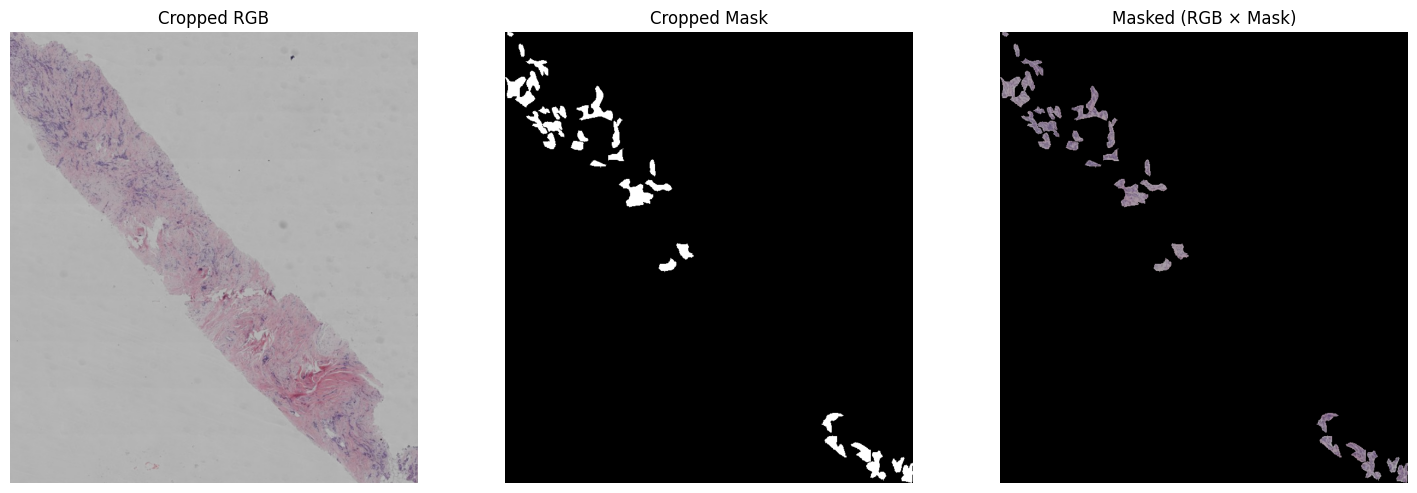

In [19]:
# 5. Apply Multiplicative Masking (as in training pipeline)
def apply_multiplicative_mask(img, mask):
    """Apply mask multiplicatively: normalize mask to [0,1] and multiply with RGB."""
    img_float = img.astype(np.float32)
    mask_float = mask.astype(np.float32)
    
    # Normalize mask to [0, 1]
    if mask_float.max() > 0:
        mask_float = mask_float / 255.0
    
    # Broadcast to 3 channels and multiply
    mask_3ch = np.repeat(mask_float[..., None], 3, axis=-1)
    masked_img = img_float * mask_3ch
    
    return masked_img.astype(np.uint8)

# Apply masking to the cropped image
masked_cropped = apply_multiplicative_mask(img_cropped, mask_cropped)

show_images_row(
    [img_cropped, mask_cropped, masked_cropped],
    ["Cropped RGB", "Cropped Mask", "Masked (RGB × Mask)"],
    figsize=(15, 5)
)

In [ ]:
# 6. Full Preprocessing Pipeline: Compare Original vs Final
def full_preprocessing(img, mask):
    """Complete preprocessing: crop to bbox, then apply mask multiplicatively."""
    img_cropped, mask_cropped, bbox = crop_to_mask_bbox(img, mask)
    masked_result = apply_multiplicative_mask(img_cropped, mask_cropped)
    return masked_result, img_cropped, mask_cropped, bbox

# Process the sample
final_result, img_c, mask_c, bbox_info = full_preprocessing(img, mask)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(img)
axes[0].set_title(f"Original\n{img.shape[0]}×{img.shape[1]}")
axes[0].axis("off")

axes[1].imshow(mask, cmap="gray")
axes[1].set_title(f"Mask\n{mask.shape[0]}×{mask.shape[1]}")
axes[1].axis("off")

axes[2].imshow(img_c)
axes[2].set_title(f"Cropped to BBox\n{img_c.shape[0]}×{img_c.shape[1]}")
axes[2].axis("off")

axes[3].imshow(final_result)
axes[3].set_title(f"Final (Cropped+Masked)\n{final_result.shape[0]}×{final_result.shape[1]}")
axes[3].axis("off")

plt.tight_layout()
plt.show()

print(f"Area reduction: {img.shape[0]*img.shape[1]} → {final_result.shape[0]*final_result.shape[1]} pixels")

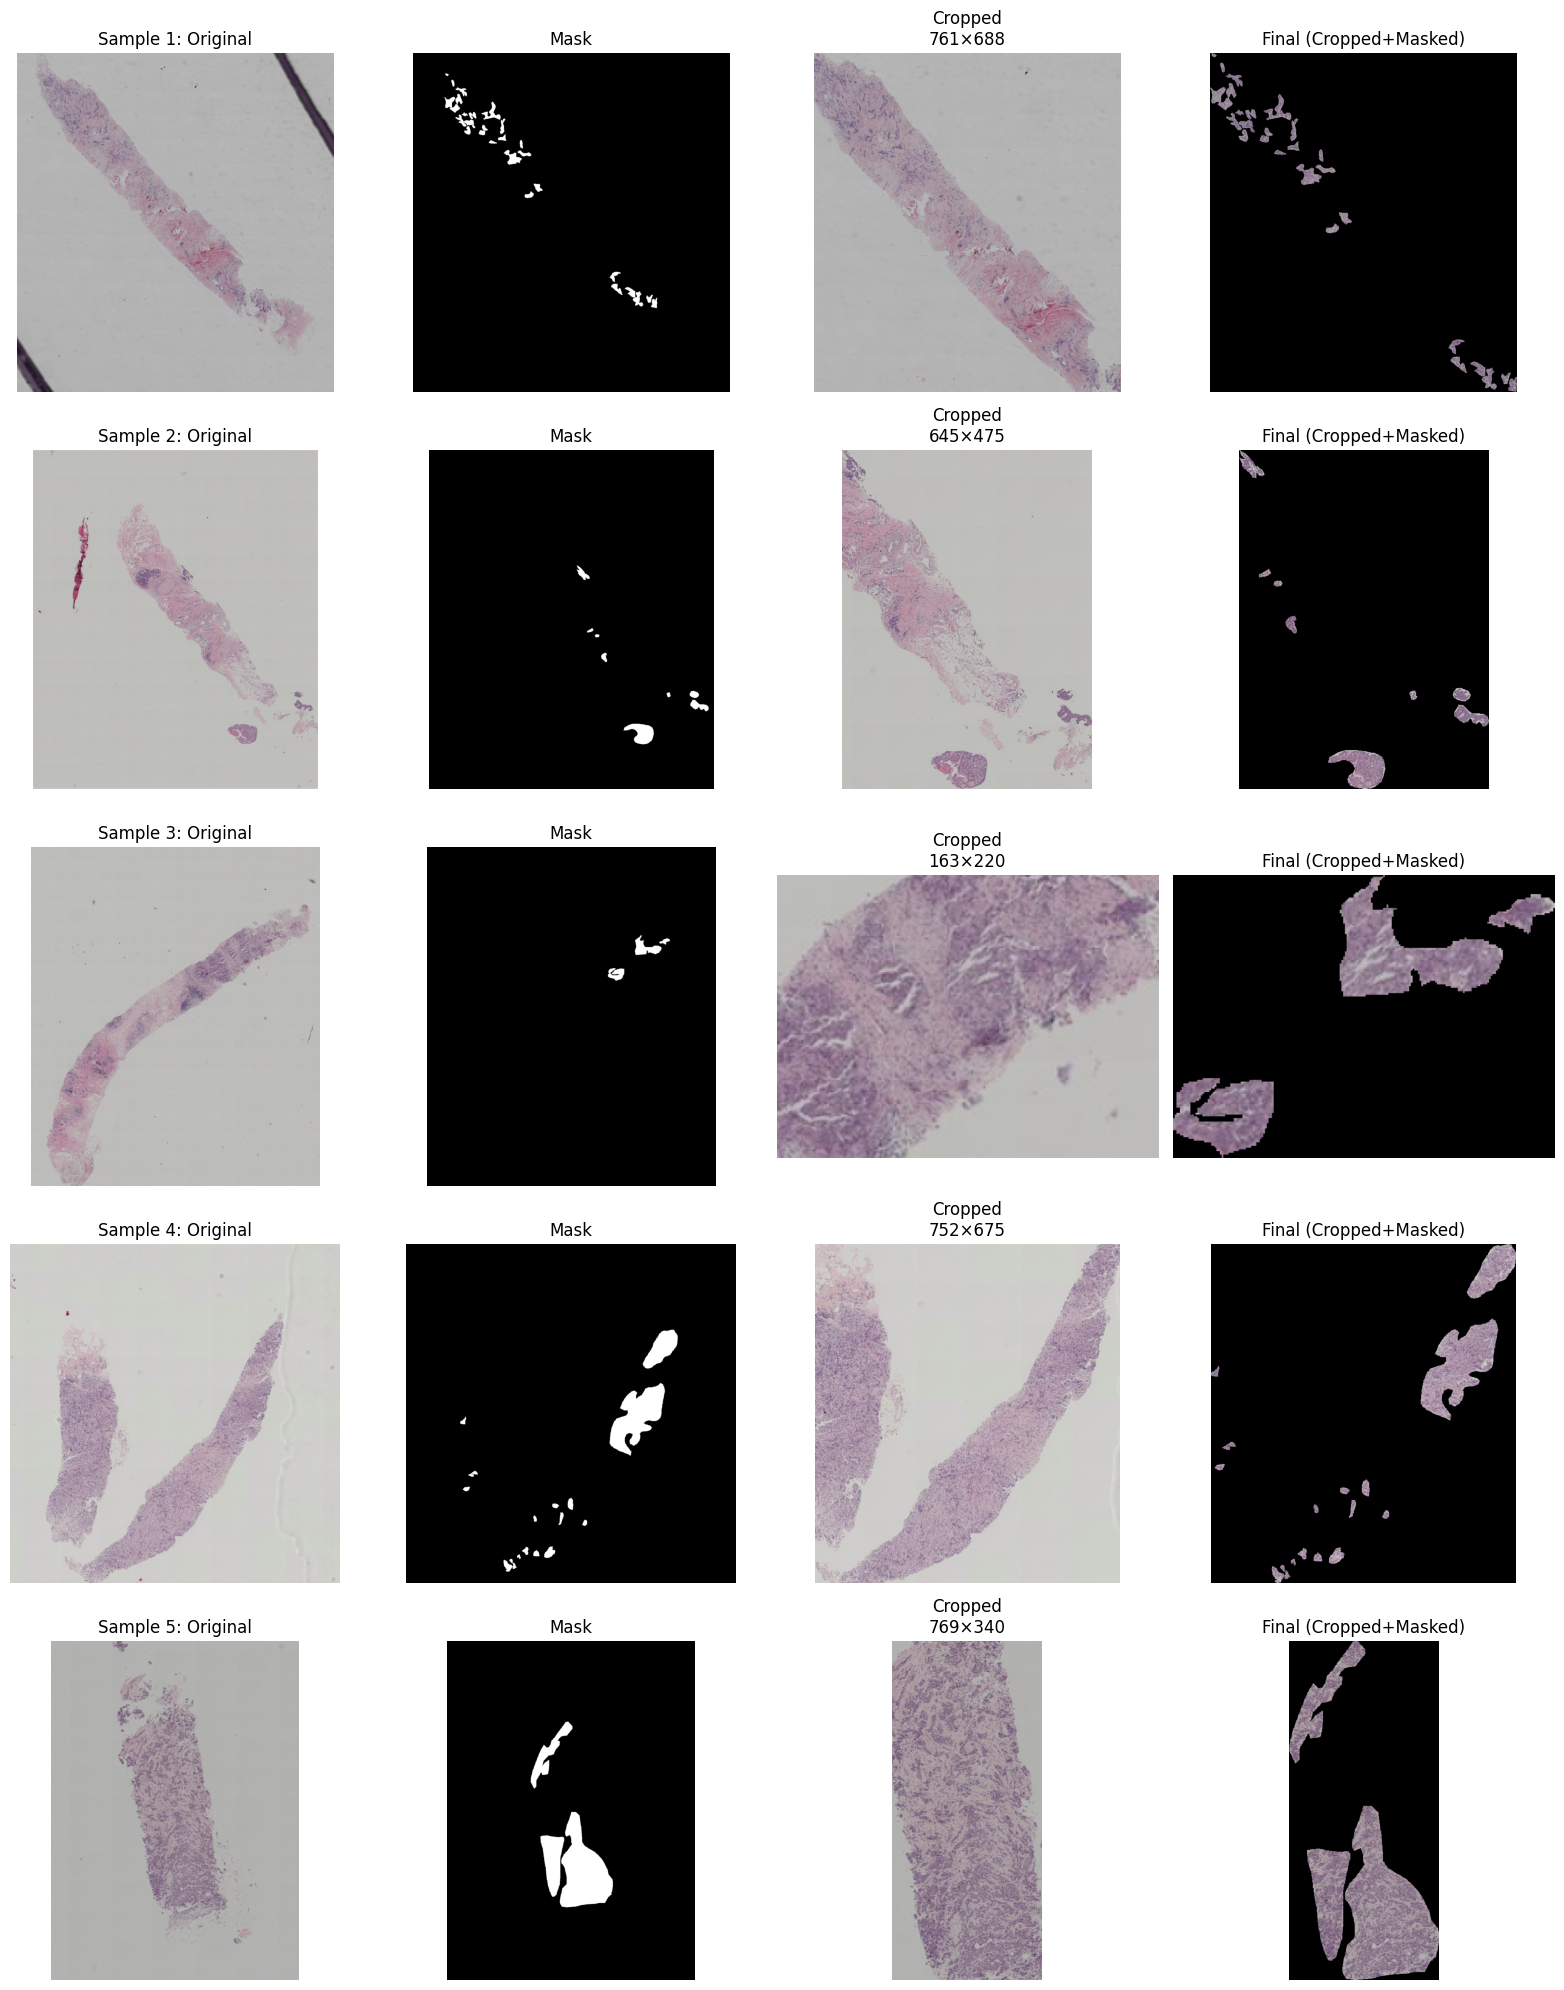

In [ ]:
# 7. Process Multiple Samples to Show Variety
num_samples = min(5, len(sample_indices))

fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

for i, sample_idx in enumerate(sample_indices[:num_samples]):
    # Load image and mask
    img_i, mask_i = load_image_and_mask(sample_idx, data_dir)
    
    # Apply full preprocessing
    final_i, img_c_i, mask_c_i, bbox_i = full_preprocessing(img_i, mask_i)
    
    # Plot
    axes[i, 0].imshow(img_i)
    axes[i, 0].set_title(f"Sample {i+1}: Original")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(mask_i, cmap="gray")
    axes[i, 1].set_title("Mask")
    axes[i, 1].axis("off")
    
    axes[i, 2].imshow(img_c_i)
    axes[i, 2].set_title(f"Cropped\n{img_c_i.shape[0]}×{img_c_i.shape[1]}")
    axes[i, 2].axis("off")
    
    axes[i, 3].imshow(final_i)
    axes[i, 3].set_title(f"Final (Cropped+Masked)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()

## Augmentation Demo
Now let's see how the Albumentations-based augmentations work on real images.

In [ ]:
# 8. Setup Albumentations Augmentation Pipelines
import albumentations as A

# Standard medical-style augmentations (from train_effnet_mask.py)
aug_standard = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=15,
        border_mode=0,
        p=0.5,
    ),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=10, p=0.3),
    A.RandomBrightnessContrast(
        brightness_limit=0.1, contrast_limit=0.1, p=0.3
    ),
])

# Pretrained-style augmentations (adds heavier color/texture transforms)
aug_pretrained = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.1,
        rotate_limit=15,
        border_mode=0,
        p=0.5,
    ),
    A.ElasticTransform(alpha=50, sigma=5, alpha_affine=10, p=0.3),
    A.RandomBrightnessContrast(
        brightness_limit=0.1, contrast_limit=0.1, p=0.3
    ),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.GaussNoise(var_limit=(5.0, 20.0), p=0.3),
])

print("✓ Augmentation pipelines ready")

In [ ]:
# 9. Apply Standard Augmentations to a Sample
# Pick a sample and crop it first
sample_for_aug = sample_indices[0]
img_aug, mask_aug = load_image_and_mask(sample_for_aug, data_dir)
img_aug_cropped, mask_aug_cropped, _ = crop_to_mask_bbox(img_aug, mask_aug)

# Generate multiple augmented versions
np.random.seed(42)
num_aug_samples = 4

fig, axes = plt.subplots(2, num_aug_samples + 1, figsize=(18, 8))

# Show original
axes[0, 0].imshow(img_aug_cropped)
axes[0, 0].set_title("Original\n(Cropped)")
axes[0, 0].axis("off")

axes[1, 0].imshow(mask_aug_cropped, cmap="gray")
axes[1, 0].set_title("Original Mask")
axes[1, 0].axis("off")

# Generate augmented versions
for i in range(num_aug_samples):
    augmented = aug_standard(image=img_aug_cropped, mask=mask_aug_cropped)
    aug_img = augmented["image"]
    aug_mask = augmented["mask"]
    
    axes[0, i+1].imshow(aug_img)
    axes[0, i+1].set_title(f"Augmented #{i+1}")
    axes[0, i+1].axis("off")
    
    axes[1, i+1].imshow(aug_mask, cmap="gray")
    axes[1, i+1].set_title(f"Augmented Mask #{i+1}")
    axes[1, i+1].axis("off")

plt.suptitle("Standard Medical-Style Augmentations", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# 10. Apply Pretrained-Style Augmentations (Heavier)
fig, axes = plt.subplots(2, num_aug_samples + 1, figsize=(18, 8))

# Show original
axes[0, 0].imshow(img_aug_cropped)
axes[0, 0].set_title("Original\n(Cropped)")
axes[0, 0].axis("off")

axes[1, 0].imshow(mask_aug_cropped, cmap="gray")
axes[1, 0].set_title("Original Mask")
axes[1, 0].axis("off")

# Generate augmented versions with pretrained-style pipeline
for i in range(num_aug_samples):
    augmented = aug_pretrained(image=img_aug_cropped, mask=mask_aug_cropped)
    aug_img = augmented["image"]
    aug_mask = augmented["mask"]
    
    axes[0, i+1].imshow(aug_img)
    axes[0, i+1].set_title(f"Augmented #{i+1}")
    axes[0, i+1].axis("off")
    
    axes[1, i+1].imshow(aug_mask, cmap="gray")
    axes[1, i+1].set_title(f"Augmented Mask #{i+1}")
    axes[1, i+1].axis("off")

plt.suptitle("Pretrained-Style Augmentations (with CLAHE, Blur, Noise)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# 11. Full Pipeline with Augmentation: Crop → Augment → Mask
def full_pipeline_with_augmentation(img, mask, augmentation=None):
    """Complete training pipeline: crop, optionally augment, then apply mask."""
    # Step 1: Crop to bounding box
    img_cropped, mask_cropped, bbox = crop_to_mask_bbox(img, mask)
    
    # Step 2: Apply augmentation if provided
    if augmentation is not None:
        augmented = augmentation(image=img_cropped, mask=mask_cropped)
        img_cropped = augmented["image"]
        mask_cropped = augmented["mask"]
    
    # Step 3: Apply multiplicative mask
    final = apply_multiplicative_mask(img_cropped, mask_cropped)
    
    return final, img_cropped, mask_cropped

# Demonstrate on a sample
sample_demo = sample_indices[1]
img_demo, mask_demo = load_image_and_mask(sample_demo, data_dir)

# Without augmentation
final_no_aug, cropped_no_aug, mask_no_aug = full_pipeline_with_augmentation(
    img_demo, mask_demo, augmentation=None
)

# With standard augmentation
final_with_aug, cropped_with_aug, mask_with_aug = full_pipeline_with_augmentation(
    img_demo, mask_demo, augmentation=aug_standard
)

# With pretrained augmentation
final_with_pretrained, cropped_with_pretrained, mask_with_pretrained = full_pipeline_with_augmentation(
    img_demo, mask_demo, augmentation=aug_pretrained
)

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(cropped_no_aug)
axes[0, 0].set_title("Cropped (No Aug)")
axes[0, 0].axis("off")

axes[0, 1].imshow(cropped_with_aug)
axes[0, 1].set_title("Cropped + Standard Aug")
axes[0, 1].axis("off")

axes[0, 2].imshow(cropped_with_pretrained)
axes[0, 2].set_title("Cropped + Pretrained Aug")
axes[0, 2].axis("off")

axes[1, 0].imshow(final_no_aug)
axes[1, 0].set_title("Final (No Aug)")
axes[1, 0].axis("off")

axes[1, 1].imshow(final_with_aug)
axes[1, 1].set_title("Final (Standard Aug)")
axes[1, 1].axis("off")

axes[1, 2].imshow(final_with_pretrained)
axes[1, 2].set_title("Final (Pretrained Aug)")
axes[1, 2].axis("off")

plt.suptitle("Full Pipeline Comparison: Crop → Augment → Mask", fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# 12. Compare Multiple Random Augmentations on Same Sample
# Generate 6 different random augmentations of the same image
sample_multi = sample_indices[2]
img_multi, mask_multi = load_image_and_mask(sample_multi, data_dir)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Original
img_c_orig, mask_c_orig, _ = crop_to_mask_bbox(img_multi, mask_multi)
final_orig = apply_multiplicative_mask(img_c_orig, mask_c_orig)

axes[0, 0].imshow(final_orig)
axes[0, 0].set_title("Original\n(Cropped + Masked)")
axes[0, 0].axis("off")

# Generate 7 augmented versions
for idx in range(7):
    row = (idx + 1) // 4
    col = (idx + 1) % 4
    
    # Apply full pipeline with augmentation
    final_aug, _, _ = full_pipeline_with_augmentation(
        img_multi, mask_multi, augmentation=aug_standard
    )
    
    axes[row, col].imshow(final_aug)
    axes[row, col].set_title(f"Aug #{idx+1}")
    axes[row, col].axis("off")

plt.suptitle("Multiple Random Augmentations of Same Sample", fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("Each augmentation applies random geometric transforms, elastic deformations,")
print("and brightness/contrast changes to create diverse training samples.")